<img src="../../data/images/gempy_logo.png" />

# <center> From Maps to Models - Tutorials for structural geological modeling using GemPy and GemGIS</center>

# Model 3 - Faulted Layers


This third notebook in this tutorial series builds upon the [first notebook](model1_Horizontal_Layers.ipynb) ([notebook on Github](https://nbviewer.org/github/cgre-aachen/gemgis_data/blob/main/notebooks/01_basic_modeling/model1_Horizontal_Layers.ipynb)) and [second notebook](model2_Folded_Layers.ipynb) ([notebook on Github](https://nbviewer.org/github/cgre-aachen/gemgis_data/blob/main/notebooks/01_basic_modeling/model2_Folded_Layers.ipynb)) where horizontal and folded layers were modeled, respectively. This notebook illustrates how to create a simple sample model of faulted layers in `GemPy`. The model consists of three parallel layers and two faults and has an extent of 1000 m by 1000 m with a vertical extent of 600 m. 

If you have not gone through the introduction notebook for the course, please check it out: [Introduction Notebook](../00_introduction_to_structural_modeling.ipynb) ([notebook on Github](https://nbviewer.org/github/cgre-aachen/gemgis_data/blob/main/notebooks/00_introduction_to_structural_modeling.ipynb))



<div class="alert alert-block alert-success">
<b>In this tutorial, you will learn the following:</b> <br>
- Get an understanding of how faults are modeled/displayed in GemPy<br>
- How to build a simple model consisting of <b>faulted layers</b> belonging to <b>one Series</b><br>

</div>

## Contents

1. [Installing GemPy](#installing-gempy)
2. [Importing Libraries](#importing-libraries)
3. [Data Preparation](#data-preparation)
    1. [Importing Interface Points](#importing-interface-points)
    2. [Importing Orientations](#importing-orientations)
4. [GemPy Model Calculation](#gempy-model-calculation)
    1. [Creating the GemPy Model](#creating-the-gempy-model)
    2. [Inspecting the Surfaces](#inspecting-the-surfaces)
    3. [Inspecting the Input Data](#inspecting-the-input-data)
    4. [Map Stack to Surfaces](#map-stack-to-surfaces)
    5. [Setting Faults](#setting-faults)
    6. [Plotting Input Data in 2D](#plotting-the-input-data-in-2d)
    7. [Plotting Input Data in 3D](#plotting-the-input-data-in-3d)
    8. [Setting the Interpolator](#setting-the-interpolator)
    9. [Computing the Model](#computing-the-model)
5. [Model Visualization and Post-Processing](#model-visualization-and-post-processing)
    1. [Visualizing Cross Sections of the Computed Model](#visualizing-cross-sections-of-the-computed-model)
    2. [Visualizing the computed model in 3D](#visualizing-the-computed-model-in-3d)
6. [Conclusions](#conclusions)
7. [Outlook](#outlook)
8. [Licensing](#licensing)



<img src="../images/model3.png" width=500/>


In reality, most geological settings are formed by a concatenation of depositional phases partitioned by unconformity boundaries and subjected to tectonic stresses that displace and deform the layers. While the interpolation is able to represent realistic folding – given enough data – the method fails to describe discontinuities. To overcome this limitation, it is possible to combine several scalar fields to recreate the desired result. So far, the implemented discontinuities in GemPy are unconformities and infinite faults. Both types are computed by specific combinations of independent scalar fields. To display the offset of faults, a drift function is calculated. 


Faults require the same input data as layers, interface points and orientations. `GemPy` has to be told that faults are present in the model in order to treat them as such. This is done with the function `gp.set_is_fault()` where you pass the name of the faults. 


<img src="../../data/images/model3_fig1.PNG" width=500/>
Source: <a href="https://doi.org/10.5194/gmd-12-1-2019">de la Varga et al. (2019)</a>

<a id='installing-gempy'></a>

# Installing GemPy

If you have not installed `GemPy` yet, please follow the [installation instructions](https://docs.gempy.org/installation.html). If you encounter any issues, feel free to open a new discussion at [GemPy Discussions](https://github.com/cgre-aachen/gempy/discussions). If you encounter an error in the installation process, feel free to also open an issue at [GemPy Issues](https://github.com/cgre-aachen/gempy/issues). There, the `GemPy` development team will help you out. 

<a id='importing-libraries'></a>

# Importing Libraries

For this notebook, we need the `pandas` library for the data preparation, `matplotlib` for plotting and of course the `gempy` library. The `gempy_viewer` library is used to plot the modeling results. Any warnings that may appear can be ignored for now. 

In [1]:
import pandas as pd
import gempy as gp
import gempy_viewer as gpv
import matplotlib.pyplot as plt

Setting Backend To: AvailableBackends.numpy


<a id='data-preparation'></a>
# Data Preparation

For this model, the only thing that needs to be done is loading the already created interface points and orientations. In the next tutorials, you will create the data yourself and process it further to make it usable for GemPy. 

<a id='importing-interface-points'></a>
## Importing Interface Points

We are using the `pandas` library ([Pandas](https://pandas.pydata.org/docs/)) to load the interface points that were prepared beforehand and stored as CSV-file (comma-separated-file). The only information that is needed are the location of the interface point (`X`, `Y`, `Z`) and the `formation` it belongs to. You may have to adjust the `delimiter` (`'\t'`, `','`, `';'`, `' '`) when loading the file.

In [2]:
interfaces = pd.read_csv('../../data/model3/model3_interfaces.csv', 
                         delimiter = ';')
interfaces.head()

,X,Y,Z,formation
0,200,250,-100,Layer1
1,200,500,-100,Layer1
2,200,750,-100,Layer1
3,200,250,-200,Layer2
4,200,500,-200,Layer2


<a id='importing-orientations'></a>

## Importing Orientations

The orientations will also be loaded using `pandas`. In addition to the location and the formation the orientation belongs to, the dip value, azimuth value (dip direction) and a polarity value (mostly set to 1 by default) needs to be provided. As the model will feature faulted layers, the dip and the azimuth values may be variable. Orientations are provided for all three modeled layers. 

In [3]:
orientations = pd.read_csv('../../data/model3/model3_orientations.csv', 
                           delimiter=';')
orientations.head()

,X,Y,Z,formation,dip,azimuth,polarity
0,200,500,-100,Layer1,0,0,1
1,800,500,-100,Layer1,0,0,1
2,500,500,-300,Layer1,0,0,1
3,250,500,-100,Fault1,60,90,1
4,750,500,-100,Fault2,60,270,1


<a id='gempy-model-calculation'></a>

# GemPy Model Calculation

The following part introduces the main steps of creating a model in `GemPy`. 

The creation of a `GemPy` Model follows particular steps which will be performed in the following:

1. Create new model and data initiation: `gp.create_geomodel()`
2. Map Stack to Surfaces: `gp.map_stack_to_surfaces()`
3. [...]
4. Computing the Model: `gp.compute_model()`

<a id='creating-the-gempy-model'></a>

## Creating the GemPy Model and Data Initiation

The first step is to create a new empty `GemPy` model by providing a name for it. 

In addition, the `extent` of the model (`xmin`, `xmax`, `ymin`, `ymax`, `zmin`, `zmax`) and the `resolution` in `X`, `Y`and `Z` direction (`res_x`, `res_y`, `res_z`, equal to the number of cells in each direction) will be set using lists of values. If you want to provide cells with a certain size, you would have to calculate the following. It is important to convert the resulting number of cells into an `int` as only integer values for the number of cells are valid. 

```python
res_x = int((xmax-xmin)/cell_size_x)
res_y = int((ymax-ymin)/cell_size_y)
res_z = int((zmax-zmin)/cell_size_z)
```

The interface points (`surface_points_df`) and orientations (`orientations_df`) will be passed as strings with the location of the CSV files. Please mind that you may have to edit the `pandas_reader_kwargs` by adding the `'sep'` key and the delimiter `'\t'` as item of a dictionary.

In [4]:
geo_model: gp.data.GeoModel = gp.create_geomodel(
    project_name='Model3_Faulted_Layers',
    extent=[0, 1000, 0, 1000, -600, 0], 
    resolution=[100, 100, 100],  # * Here we define the number of octree levels. If octree levels are defined, the resolution is ignored.
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations='../../data/model3/model3_orientations.csv',
        path_to_surface_points='../../data/model3/model3_interfaces.csv',
        pandas_reader_kwargs = {'sep': ';'}
    )
)

<a id='inspecting-the-surfaces'></a>

## Inspecting the Surfaces

The model consists of three different layers or surfaces now which all belong to the `Default series`. During the next step, the proper `Series` will be assigned to the surfaces. Using the `structural_frame`-attribute again, we can check which layers were loaded.

In [5]:
geo_model.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formation,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Fault1,
	color=#015482,
	is_active=True
),
Element(
	name=Fault2,
	color=#9f0052,
	is_active=True
),
Element(
	name=Layer1,
	color=#ffbe00,
	is_active=True
),
Element(
	name=Layer2,
	color=#728f02,
	is_active=True
),
Element(
	name=Layer3,
	color=#443988,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

<a id='inspecting-the-input-data'></a>

## Inspecting the Input Data

The loaded interface points and orientations can again be inspected using the `surface_points_copy`- and `orientations_copy`-attributes. Using the `df`-attribute of this object will convert the displayed table in a `pandas` `DataFrame`.

In [6]:
geo_model.surface_points_copy.df.head()

,X,Y,Z,id,nugget
0,250.0,50.0,-100.0,56362979,0.00002
1,250.0,950.0,-100.0,56362979,0.00002
2,750.0,50.0,-100.0,116670087,0.00002
3,750.0,950.0,-100.0,116670087,0.00002
4,200.0,250.0,-100.0,206808710,0.00002


In [7]:
geo_model.orientations_copy.df.head()

,X,Y,Z,G_x,G_y,G_z,id,nugget
0,250.0,500.0,-100.0,0.866025,5.302876e-17,0.5,56362979,0.01
1,750.0,500.0,-100.0,-0.866025,-1.590863e-16,0.5,116670087,0.01
2,200.0,500.0,-100.0,0.000000,0.000000e+00,1.0,206808710,0.01
3,800.0,500.0,-100.0,0.000000,0.000000e+00,1.0,206808710,0.01
4,500.0,500.0,-300.0,0.000000,0.000000e+00,1.0,206808710,0.01


<a id='map-stack-to-surfaces'></a>

## Map Stack to Surfaces

During this step, all three layers of the model are assigned to the `Strata1` series. We know that the layers modeled here are parallel. If the layers were not parallel as shown in the next models, multiple series would be defined. Further, we define two separate series for `Fault1` and `Fault2`. The order within one series also defines the age relations within this series and has to be according to the depositional events of the layers.

In [8]:
gp.map_stack_to_surfaces(gempy_model=geo_model,
                         mapping_object=
                         {
                          'Fault1': ('Fault1'),
                          'Fault2': ('Fault2'),
                          'Strata1': ('Layer1', 'Layer2', 'Layer3'),                          
                         },
                         remove_unused_series=True)
geo_model.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Fault1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Fault1,
	color=#015482,
	is_active=True
)
]
),
StructuralGroup(
	name=Fault2,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Fault2,
	color=#9f0052,
	is_active=True
)
]
),
StructuralGroup(
	name=Strata1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Layer1,
	color=#ffbe00,
	is_active=True
),
Element(
	name=Layer2,
	color=#728f02,
	is_active=True
),
Element(
	name=Layer3,
	color=#443988,
	is_active=True
)
]
)
],
	fault_relations=
[[False, False, False],
 [False, False, False],
 [False, False, False]],

<a id='setting-faults'></a>

## Setting Faults 

In addition to `Series` for the layers, we defined two `Series` containing the two faults. In order for `GemPy` to recognize the faults as faults, we need to define them as faults (`gp.set_is_fault()`). 

In [9]:
gp.set_is_fault(frame=geo_model.structural_frame,
                fault_groups = ['Fault1', 'Fault2'])

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Fault1,
	structural_relation=StackRelationType.FAULT,
	elements=[
Element(
	name=Fault1,
	color=#527682,
	is_active=True
)
]
),
StructuralGroup(
	name=Fault2,
	structural_relation=StackRelationType.FAULT,
	elements=[
Element(
	name=Fault2,
	color=#527682,
	is_active=True
)
]
),
StructuralGroup(
	name=Strata1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Layer1,
	color=#ffbe00,
	is_active=True
),
Element(
	name=Layer2,
	color=#728f02,
	is_active=True
),
Element(
	name=Layer3,
	color=#443988,
	is_active=True
)
]
)
],
	fault_relations=
[[False, False,  True],
 [False, False,  True],
 [False, False, False]],

<a id='plotting-the-input-data-in-2d'></a>

## Plotting the input data in 2D using Matplotlib

The input data can now be visualized in 2D using `matplotlib`. This might for example be useful to check if all points and measurements are defined the way we want them to. Using the function `plot_2d()`, we attain a 2D projection of our data points onto a plane of chosen direction (we can choose this attribute to be either `'x'`, `'y'`, or `'z'`).

C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_viewer\API\_plot_2d_API.py:176: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


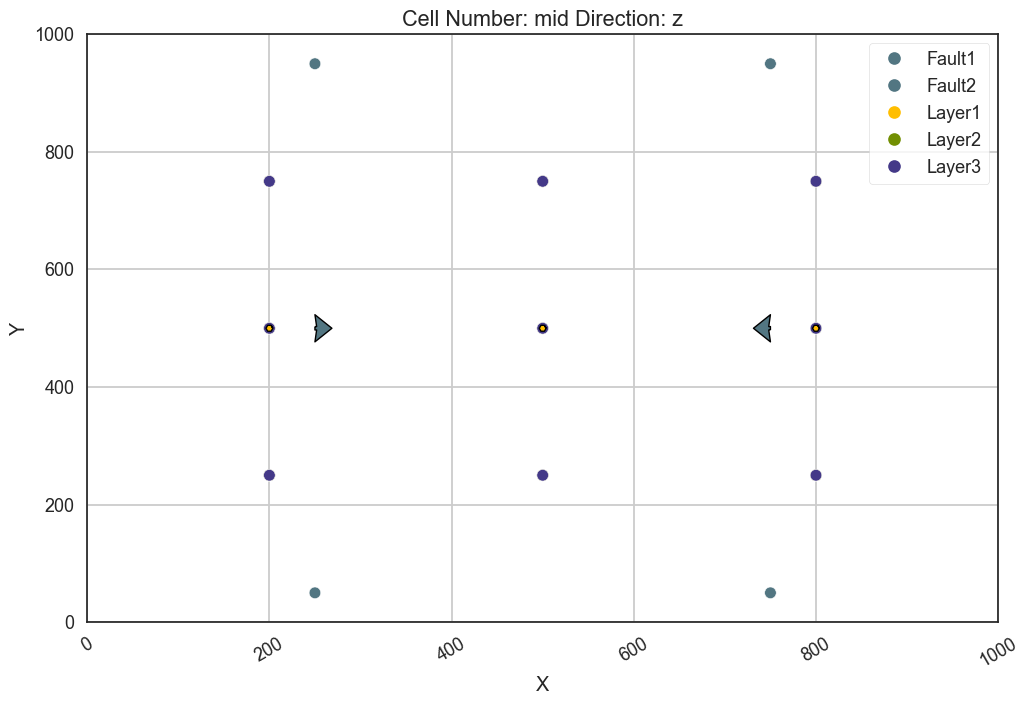

In [10]:
gpv.plot_2d(geo_model, 
           direction='z', 
           show_lith=False, 
           show_boundaries=False)
plt.grid()

<a id='plotting-the-input-data-in-3d'></a>

## Plotting the input data in 3D using PyVista

The input data can also be viszualized using the `pyvista` package. In this view, the interface points are visible as well as the orientations (marked as arrows) which indicate the normals of each orientation value. 

The `pyvista` package requires the Visualization Toolkit (VTK) to be installed.

C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


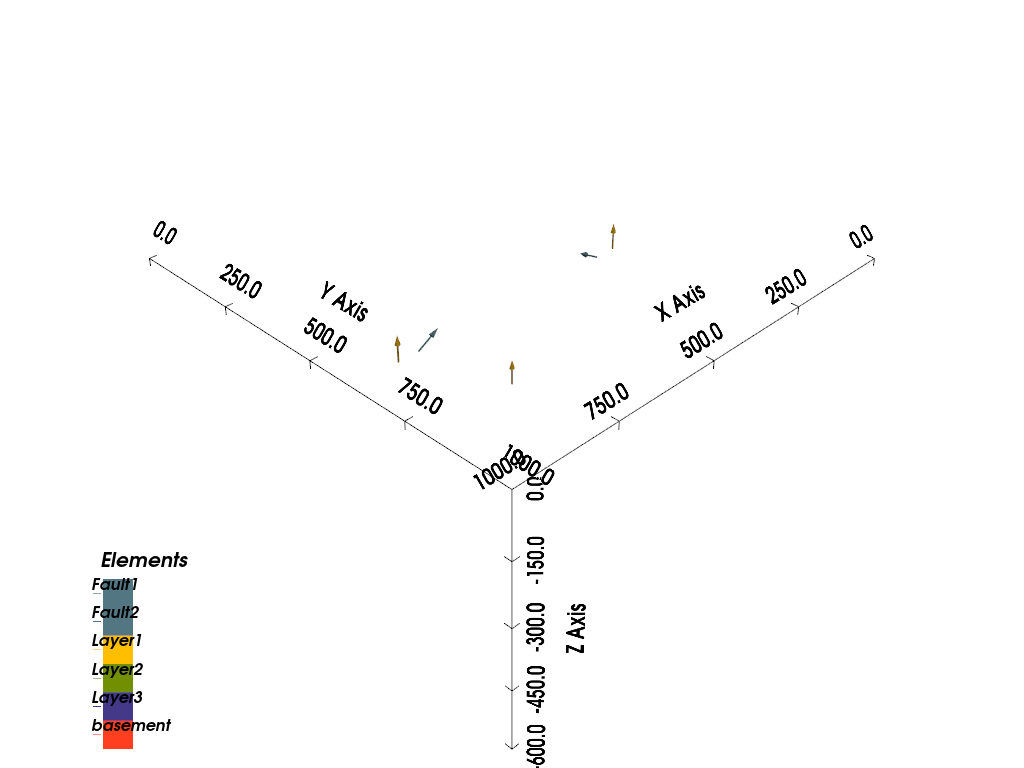

In [11]:
gpv.plot_3d(geo_model, 
            image=False, 
            show_lith=False,
            plotter_type='basic',
            kwargs_plotter= {'notebook':True},)

<a id='setting-the-interpolator'></a>
## Setting the interpolator

Unlike previous versions, GemPy 3 doesn’t rely on theano or asera. Instead, it utilizes numpy or tensorflow. Consequently, we no longer need to recompile all theano functions (TensorFlow uses eager execution; we found no notable speed difference after profiling the XLA compiler).

The parameters used for the interpolation are stored in gempy.core.data.GeoModel.interpolation_options. These parameters have sensible default values that you can modify if necessary. However, we advise caution when changing these parameters unless you fully understand their implications.

Display the current interpolation options

In [12]:
geo_model.interpolation_options

InterpolationOptions(kernel_options=KernelOptions(range=1.7, c_o=10.0, uni_degree=1, i_res=4.0, gi_res=2.0, number_dimensions=3, kernel_function=AvailableKernelFunctions.cubic, kernel_solver=Solvers.DEFAULT, compute_condition_number=False, optimizing_condition_number=False, condition_number=None), evaluation_options=EvaluationOptions(_number_octree_levels=1, _number_octree_levels_surface=4, octree_curvature_threshold=-1.0, octree_error_threshold=1.0, octree_min_level=2, mesh_extraction=True, mesh_extraction_masking_options=<MeshExtractionMaskingOptions.INTERSECT: 3>, mesh_extraction_fancy=True, evaluation_chunk_size=500000, compute_scalar_gradient=False, verbose=False), debug=True, cache_mode=<CacheMode.IN_MEMORY_CACHE: 3>, cache_model_name='Model3_Faulted_Layers', block_solutions_type=<BlockSolutionType.DENSE_GRID: 2>, sigmoid_slope=5000000, debug_water_tight=False)

<a id='computing-the-model'></a>

## Computing the model

At this point, we have all we need to compute our full model via `gp.compute_model()`. By default, this will return two separate solutions in the form of arrays. The first provides information on the lithological formations, the second on the fault network in the model, which is not present in this example. 

In [13]:
sol = gp.compute_model(geo_model, 
                       compute_mesh=True)

Setting Backend To: AvailableBackends.numpy
Chunking done: 15 chunks


C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_engine\modules\activator\_soft_segment.py:95: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + bt.t.exp(x))


Chunking done: 15 chunks
Chunking done: 77 chunks


C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_engine\modules\activator\_soft_segment.py:95: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + bt.t.exp(x))
C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_engine\modules\activator\_soft_segment.py:95: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + bt.t.exp(x))


In [14]:
sol

Solutions(4 Octree Levels, 5 DualContouringMeshes)

In [15]:
geo_model.solutions

Solutions(4 Octree Levels, 5 DualContouringMeshes)

<a id='model-visualization-and-post-processing'></a>

# Model Visualization and Post-Processing

<a id='visualizing-cross-sections-of-the-computed-model'></a>

## Visulazing Cross Sections of the computed model

Cross sections in different `direction`s and at different `cell_number`s can be displayed. Here, we see the horizontal layers in the one direction and the faulted layers in the other direction.

C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_viewer\API\_plot_2d_API.py:176: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


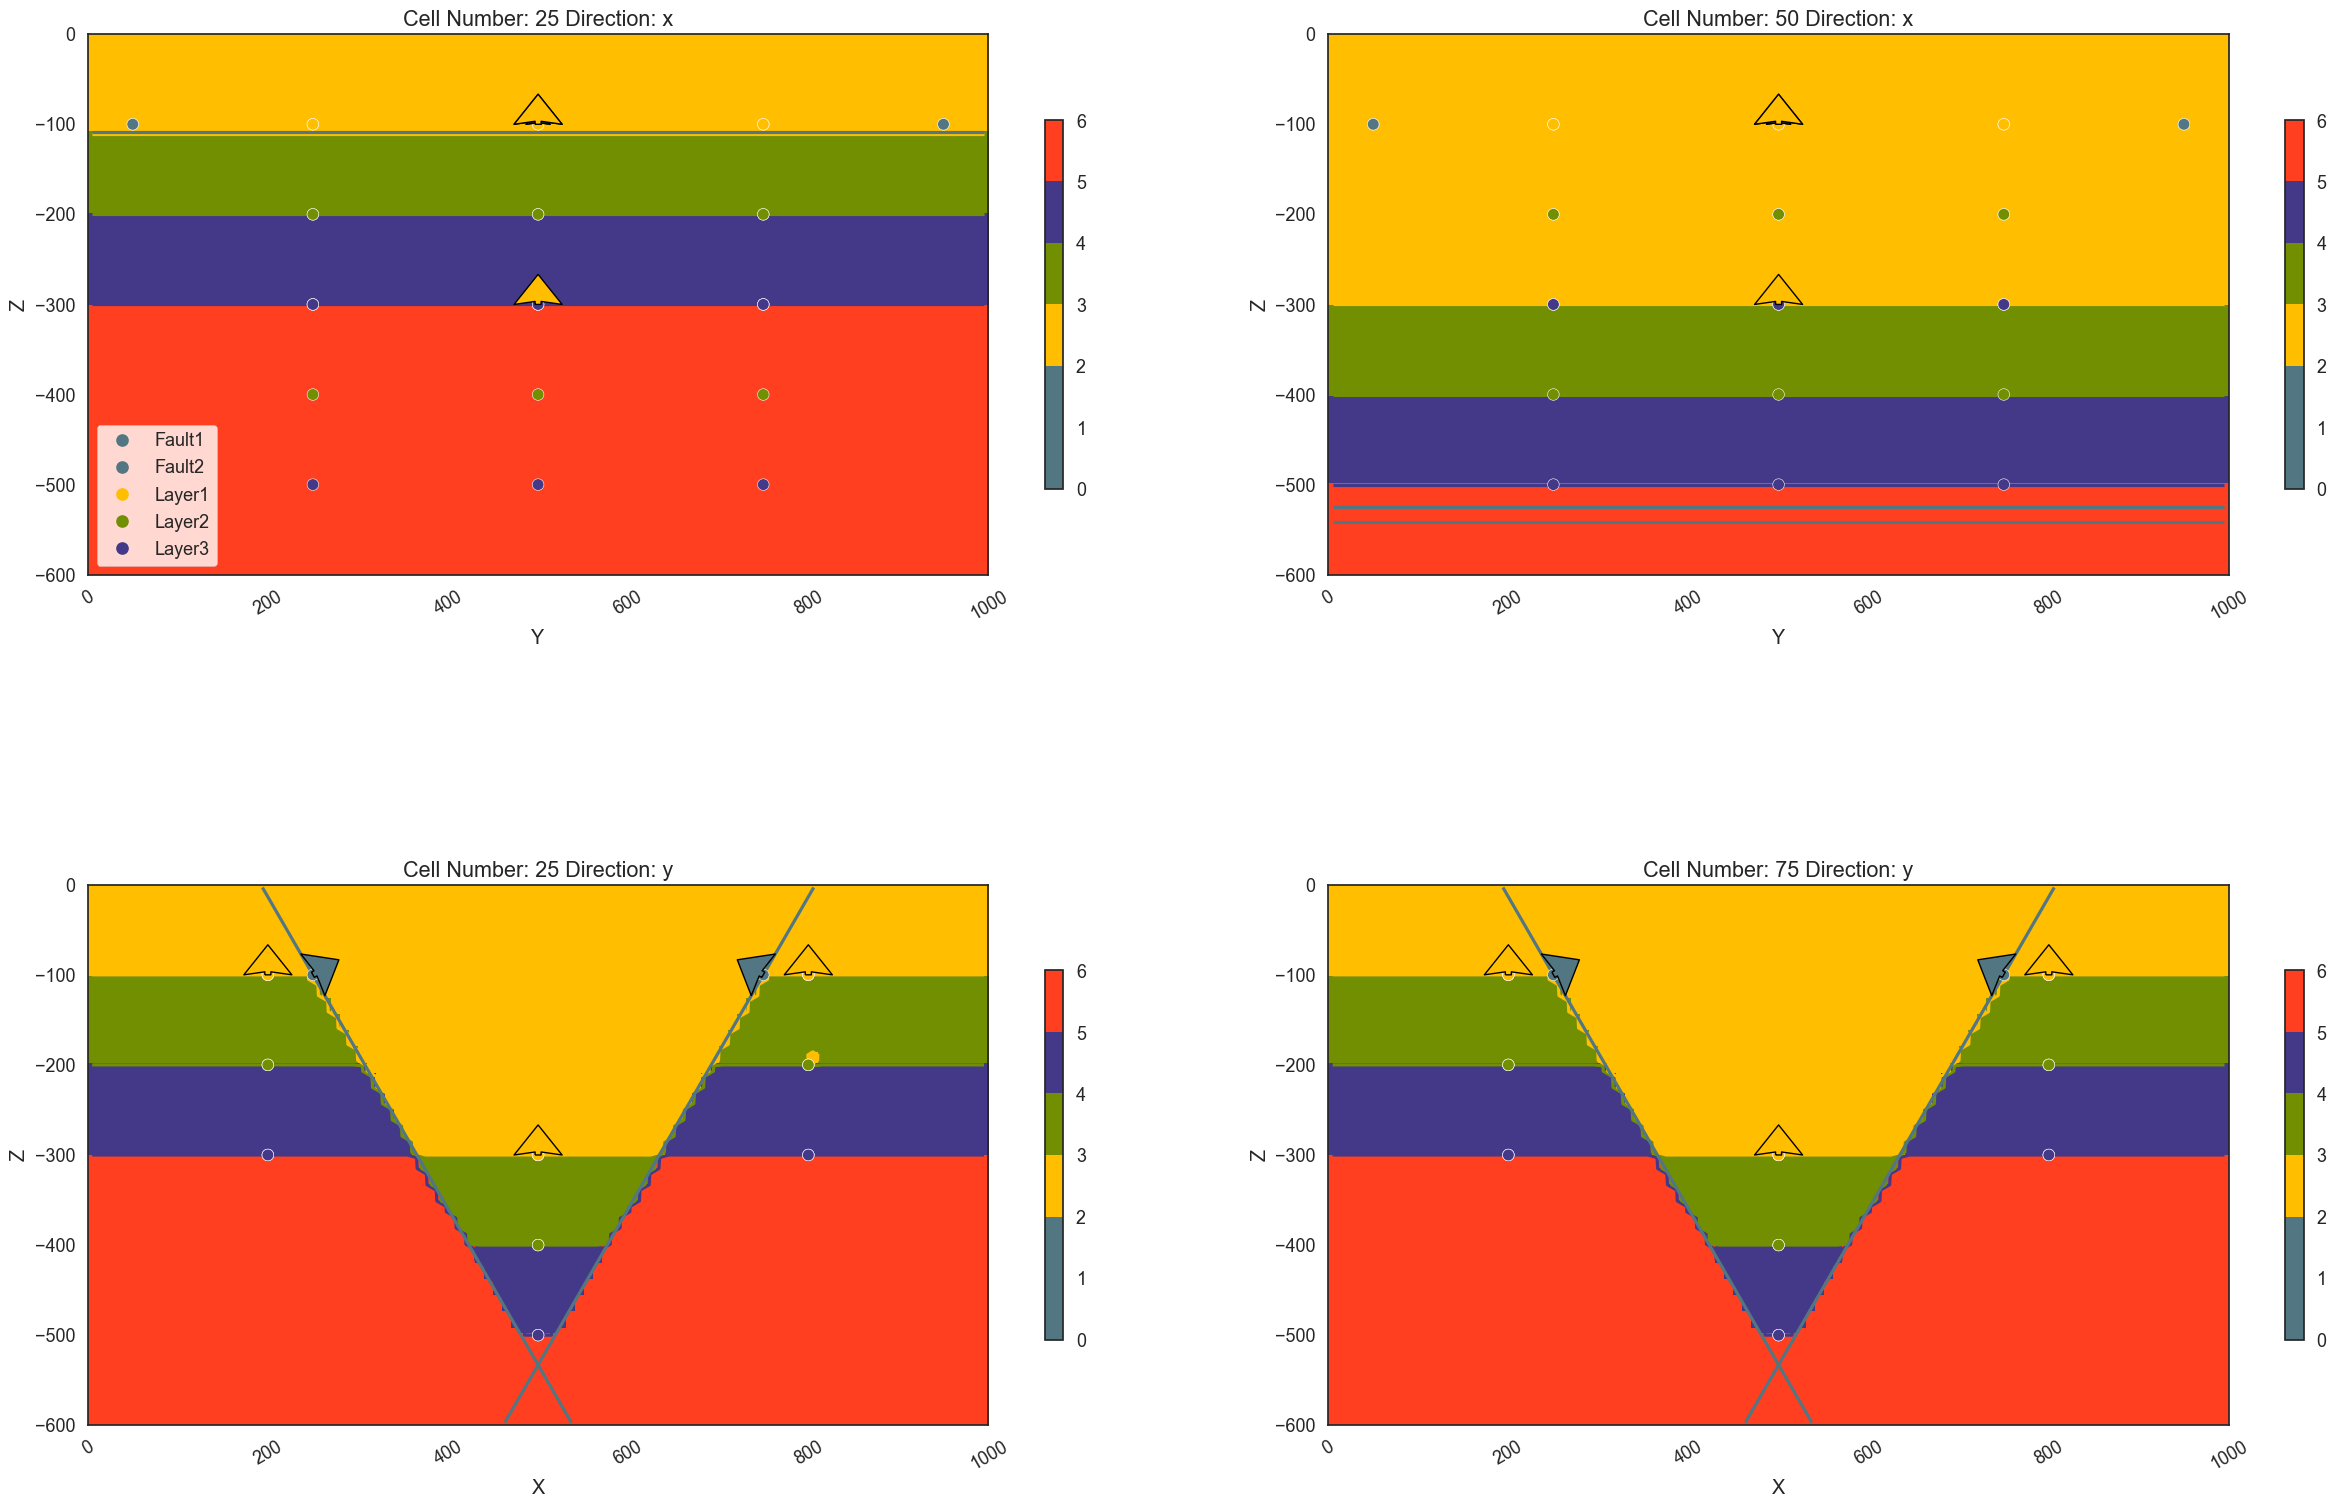

In [16]:
gpv.plot_2d(geo_model, 
           direction=['x', 'x', 'y', 'y'], 
           cell_number=[25, 50, 25, 75], 
           show_topography=False, 
           show_data=True)

Next to the lithology data, we can also plot the calculated scalar field.

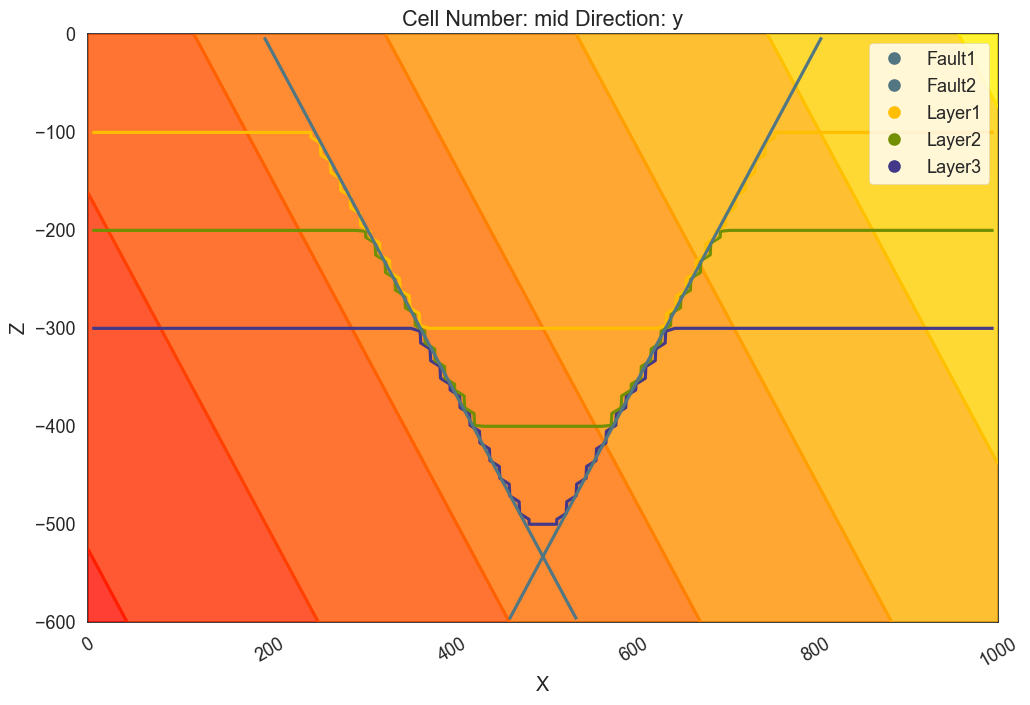

In [17]:
gpv.plot_2d(geo_model, direction='y', show_data=False, show_scalar=True, show_lith=False)

<a id='visualizing-the-computed-model-in-3d'></a>

# Visualizing the computed model in 3D

The computed model can be visualized in 3D using the `pyvista` library. Setting `kwargs_plotter= {'notebook':True}` will open an interactive windows and the model can be rotated and zooming is possible. 

C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_viewer\modules\plot_3d\drawer_surfaces_3d.py:38: PyVistaDeprecationWarning: 
../../../../Anaconda3/envs/gemgis_12/Lib/site-packages/gempy_viewer/modules/plot_3d/drawer_surfaces_3d.py:38: Argument 'color' must be passed as a keyword argument to function 'BasePlotter.add_mesh'.
From version 0.50, passing this as a positional argument will result in a TypeError.
  gempy_vista.surface_actors[element.name] = gempy_vista.p.add_mesh(
C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


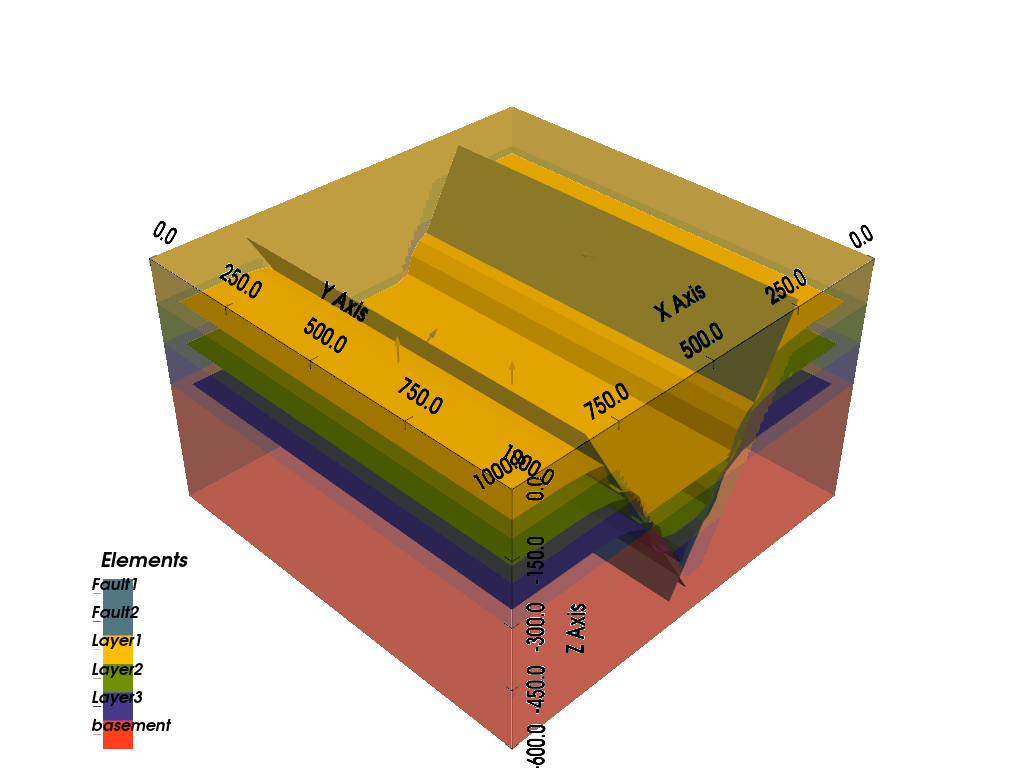

In [18]:
gpv.plot_3d(geo_model, 
                 image=False, 
                 show_topography=True,
                 plotter_type='basic', 
                 kwargs_plotter= {'notebook':True},
                 show_lith=True)

<a id='conclusions'></a>
# Conclusions

<div class="alert alert-block alert-success">
<b>In this tutorial, you have learnt the following:</b> <br>
- Get an understanding of how faults are modeled/displayed in GemPy<br>
- How to build a simple model consisting of <b>faulted layers</b> belonging to <b>one Series</b><br>

</div>


<a id='outlook'></a>
# Outlook

<div class="alert alert-block alert-success">
<b>In the next tutorial, you will learn the following:</b> <br>
- Get an understanding of how unconformities are modeled/displayed in GemPy<br>
- How to build a simple model consisting of <b>unconformable layers</b> belonging to <b>multiple Series</b><br>


</div>

[Take me to the next notebook on Github](https://nbviewer.org/github/cgre-aachen/gemgis_data/blob/main/notebooks/01_basic_modeling/model4_Truncated_Layers.ipynb)

[Take me to the next notebook locally](model4_Truncated_Layers.ipynb)

<img src="../../jose/images/fig1.png" />

<a id='licensing'></a>

## Licensing

Institute for Computational Geoscience, Geothermics and Reservoir Geophysics, RWTH Aachen University & Fraunhofer IEG, Fraunhofer Research Institution for Energy Infrastructures and Geotechnologies IEG, Authors: Alexander Juestel. For more information contact: alexander.juestel(at)ieg.fraunhofer.de

All notebooks are licensed under a Creative Commons Attribution 4.0 International License (CC BY 4.0, http://creativecommons.org/licenses/by/4.0/). References for each displayed map are provided. Most of the maps originate from the books of [Powell (1992)](https://link.springer.com/book/9783540586074) and [Bennison (1990)](https://link.springer.com/book/10.1007/978-1-4615-9630-1). References for maps with unknown origin will gladly be added.